In [1]:
import pandas
import numpy as np
import json
import glob
import seaborn
import os
import os.path
import gab
import nltk
from matplotlib.colors import ListedColormap
import matplotlib


stemmer = nltk.stem.PorterStemmer()
shootingDate = pandas.Timestamp('2018-10-27')

unigrams = glob.glob('../2019-03-17_ngrams_2/1-grams_*.csv')
bigrams = glob.glob('../2019-03-17_ngrams_2/2-grams_*.csv')
trigrams = glob.glob('../2019-03-17_ngrams_2/3-grams_*.csv')

In [2]:
def loadngrams(path):
    with open(path) as f:
        dat = {}
        f.readline()
        for l in f:
            *w, c = l.strip().split(',')
            dat[tuple(w)] = int(c)
    return dat

In [3]:
unigramsDat = {os.path.basename(k)[8:-4] : loadngrams(k) for k in unigrams}
bigramsDat = {os.path.basename(k)[8:-4] : loadngrams(k) for k in bigrams}
trigramsDat = {os.path.basename(k)[8:-4] : loadngrams(k) for k in trigrams}

In [27]:
dat = []
for m in sorted(unigramsDat.keys()):
    dat.append((len(unigramsDat[m]), len(bigramsDat[m]), len(trigramsDat[m])))

In [33]:
df_ng = pandas.DataFrame(dat, columns = ['unigrams', 'bigrams', 'trigrams'], index = pandas.to_datetime(sorted(unigramsDat.keys())))

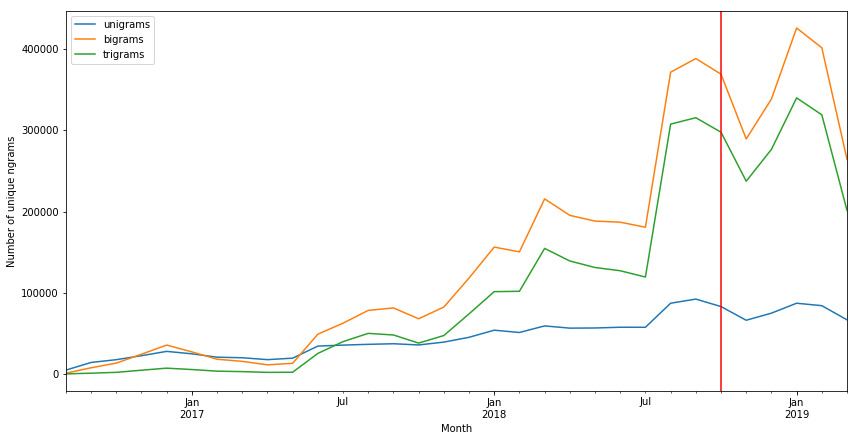

In [37]:
fig, ax = plt.subplots(figsize = (14,7))
df_ng.plot(ax=ax)
ax.axvline(shootingDate,color='r')
ax.set_xlabel("Month")
ax.set_ylabel("Number of unique ngrams")
plt.savefig('ngrams_overtime.pdf', format = 'pdf',bbox_inches='tight')

In [4]:
n = set()
for v in unigramsDat.values():
    n |= set(v.keys())

In [5]:
uni_before = {}
uni_after = {}
for m, d in unigramsDat.items():
    if gab.isBefore(m):
        for k, c in d.items():
            try:
                uni_before[k] += c
            except KeyError:
                uni_before[k] = c
    else:
        for k, c in d.items():
            try:
                uni_after[k] += c
            except KeyError:
                uni_after[k] = c

In [6]:
selectwords = set([k for k,c in sorted(uni_before.items(), key = lambda x : x[1], reverse=True)[:10000] if '@' not in k[0] and '#' not in k[0]]) & set(uni_after.keys())

In [7]:
before_words_filtered = {w:uni_before[w] for w in selectwords}
before_words_sum = sum(uni_before.values())
before_words_prob = {w : v / before_words_sum for w, v in before_words_filtered.items()}
#before_words_sum = sum(uni_before.values())
#before_words_prob_full = {w : v / before_words_sum for w, v in uni_before.items()}

In [8]:
after_words_filtered = {w:uni_after[w] for w in selectwords}
after_words_sum = sum(uni_after.values())
after_words_prob = {w : v / after_words_sum for w, v in after_words_filtered.items()}

In [9]:
l = []
for w in selectwords:
    p = after_words_prob[w]
    q = before_words_prob[w]
    l.append({'word' : w[0], 'after_prob' : p, 'before_prob' : q, 'log_odds' : np.log((p/(1-p)) / (q/(1-q)) )})

In [10]:
df_words = pandas.DataFrame(l)
df_words.index = df_words['word']

In [11]:
def latexFormat(n, sigFigs = 1, add_num = True):
    if int(n) == n:
        return str(n)
    if add_num:
        return f"\\num{{{n:.4e}}}"
    else:
        return f"{n:.5f}"
def twoColumn(df, columm1, column2, values, add_num = True):
    ret = []
    ret.append('  &  '.join(2 *( ['Word'] + values)))
    ret.append('\\midrule')
    for w1, w2 in zip(columm1, column2):
        s1 = [w1.ljust(14)] + [latexFormat(v, 2, add_num = add_num).rjust(8) for v in df.loc[w1][values]]
        s2 = [w2.ljust(14)] + [latexFormat(v, 2, add_num = add_num).rjust(8) for v in df.loc[w2][values]]
        ret.append("  &  ".join(s1 + s2) + '\\\\')
    return '\n'.join(ret)

In [13]:
words_top = list(df_words.sort_values('log_odds')['word'])[:30:-1]
words_bottom = list(df_words.sort_values('log_odds')['word'])[:30]

dropBottom = ['sotu', 'museu','turno', 'edt', 'ibope', 'sep', 'pesquisas','urnas', 'pesquisa', 'ciro', 'fraude']
for w in dropBottom:
    try:
        words_bottom.remove(w)
    except ValueError:
        pass
dropTop = ['sotu', 'museu','turno', 'edt', 'ibope', 'sep', 'pesquisas','urnas', 'pesquisa', 'ciro', 'fraude']
for w in dropTop:
    try:
        words_top.remove(w)
    except ValueError:
        pass

print(twoColumn(df_words, words_top[:13], words_bottom[:13], ['log_odds'], add_num = False))

Word  &  log_odds  &  Word  &  log_odds
\midrule
omar            &   2.63687  &  alckmin         &  -4.85861\\
yellow          &   2.60067  &  !xowat4z3vq     &  -4.81171\\
2019            &   2.31179  &  irma            &  -4.09426\\
ocasio          &   2.14090  &  datafolha       &  -3.98208\\
cortez          &   2.11942  &  amoedo          &  -3.83852\\
alexandria      &   1.89482  &  candidatos      &  -3.77108\\
shutdown        &   1.88219  &  polygraph       &  -3.67191\\
barr            &   1.85697  &  candidato       &  -3.65298\\
ballots         &   1.78781  &  bonner          &  -3.27985\\
kamala          &   1.78207  &  swetnick        &  -3.23984\\
dec             &   1.71774  &  omarosa         &  -3.05904\\
feb             &   1.65586  &  kenyans         &  -3.05067\\
macron          &   1.59273  &  tse             &  -3.04765\\


In [14]:
df_words.sort_values('log_odds')

,after_prob,before_prob,log_odds,word
word,,,,
alckmin,4.053027e-07,0.000052,-4.858608,alckmin
!xowat4z3vq,1.070611e-07,0.000013,-4.811706,!xowat4z3vq
turno,1.254144e-06,0.000075,-4.095514,turno
irma,2.294166e-07,0.000014,-4.094263,irma
ibope,3.823611e-07,0.000022,-4.051531,ibope
datafolha,2.676528e-07,0.000014,-3.982081,datafolha
amoedo,3.441250e-07,0.000016,-3.838521,amoedo
candidatos,1.147083e-06,0.000050,-3.771079,candidatos
polygraph,3.441250e-07,0.000014,-3.671909,polygraph


In [15]:
len(n)

256898

In [16]:
l = []
jewTargets = gab.antiSemticTerms

for m, d in unigramsDat.items():
    r = {'date' : m}
    for t in jewTargets:
        r[t] = d.get((t,), 0)
    l.append(r)

In [17]:
def filterNgrams(triGrams, filterStrings = ('#','@'), drop_nums = True, drop_triples = True):
    vals = list(triGrams).copy()
    for fil in filterStrings:
        vals_tmp = []
        for v,c in vals:
            bad = False
            for w in v:
                if fil in w:
                    bad = True
                    break
            if not bad:
                vals_tmp.append((v,c))

        vals = vals_tmp
    if drop_nums:
        vals_tmp = []
        for v,c in vals:
            bad = False
            for w in v:
                if w.isdigit():
                    bad = True
                    break
            if not bad:
                vals_tmp.append((v,c))
        vals = vals_tmp
    if drop_triples:
        vals_tmp = []
        for v,c in vals:
            bad = True
            for w in v:
                if w != v[0]:
                    bad = False
                    break
            if not bad:
                vals_tmp.append((v,c))
        vals = vals_tmp
    return vals

In [18]:
def prettyMonth(m):
    d = pandas.Timestamp(m)
    return d.strftime("%y/%m")

def makeTopsDF(dat, normalize = False, minCount = 10, filterStrings = ('#','@', '_')):
    completes = set()
    selectTargets = []
    names = []
    l = []
    for m in sorted(dat.keys()):
        vals = sorted([(k,c) for k,c in dat[m].items() if c > minCount and k not in completes],
                      key = lambda x : x[1],
                      reverse=True
                     )
        vals = filterNgrams(vals, filterStrings = filterStrings)
        try:
            selectTargets.append((vals[0][0], vals[0][1], m))
            names.append(f"{prettyMonth(m)} - {' '.join(vals[0][0])}")
            #completes |= set([v for v, c in vals])
            completes |= set([vals[0][0]])
        except IndexError:
            pass
    for m in dat.keys():
        r = {'date' : m}
        if normalize:
            total = sum(dat[m].values())# + sum(bigramsDat[m].values()) + sum(trigramsDat[m].values())
        else:
            total = 1
        for i,(t, _, _) in enumerate(selectTargets):
            #if len(t.split()) < 2:
            try:
                r[names[i]] += dat[m].get(t, 0) / total
            except KeyError:
                r[names[i]] = dat[m].get(t, 0) / total
        l.append(r)
    df_ret = pandas.DataFrame(l)
    df_ret['date'] = pandas.to_datetime(df_ret['date'])
    df_ret.index = df_ret['date']
    del df_ret['date']
    return selectTargets, df_ret.sort_index()

In [19]:
def makeCountsDF(targetTerms, normalize = False, topN = None):
    l = []
    for m in unigramsDat.keys():
        r = {'date' : m}
        if normalize:
            total = sum(unigramsDat[m].values())# + sum(bigramsDat[m].values()) + sum(trigramsDat[m].values())
        else:
            total = 1
        for t in targetTerms:
            #if len(t.split()) < 2:
            try:
                r[stemmer.stem(t)] += unigramsDat[m].get((t,), 0) / total
            except KeyError:
                r[stemmer.stem(t)] = unigramsDat[m].get((t,), 0) / total
        l.append(r)
    df_plot = pandas.DataFrame(l)
    df_plot['date'] = pandas.to_datetime(df_plot['date'])
    df_plot.index = df_plot['date']
    del df_plot['date']
    df_plot = df_plot.sort_index()
    if topN is not None:
        targets = df_plot.sum().sort_values()[-topN:].index
        return df_plot[targets]
    return df_plot

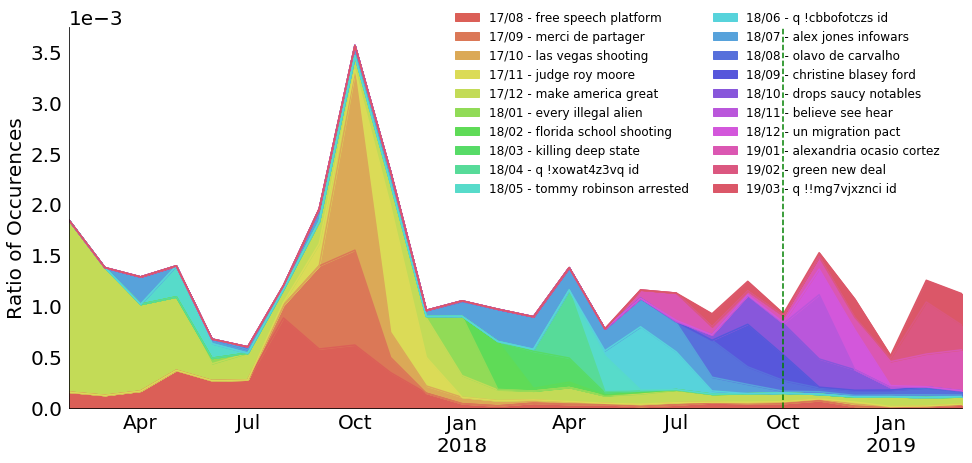

In [20]:
tops, df_plot = makeTopsDF(trigramsDat, normalize=True, filterStrings = ('#','@', '_','igger'))
fig, ax = plt.subplots(figsize = (16,7))
cmap = list(seaborn.color_palette("hls",len(df_plot.columns)))


df_plot[df_plot.columns[12:]].iloc[6:].plot.area(ax = ax, legend = True, colormap = ListedColormap(cmap))

box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(.42, 0.8),frameon=False, ncol=2, labelspacing=.5, fontsize = 12)
ax.set_xlabel("")
ax.set_ylabel("Ratio of Occurences", size = 20)
#ax.set_title("Unigram Occurences Over Time")
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.tick_params('both', which='both',labelsize=20)
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.set_xlim([pandas.Timestamp('2017-10-01'),None])
ax.yaxis.get_offset_text().set_fontsize(20)
ax.axvline(x=shootingDate, color='G', linestyle='--')


plt.savefig('trigrams_norepost.pdf', format = 'pdf',bbox_inches='tight')

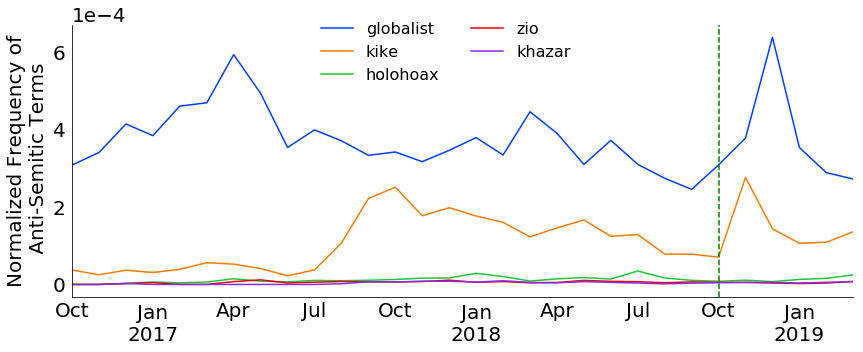

In [40]:
df_plot = makeCountsDF(jewTargets , normalize=True, topN = 5)

matplotlib.rcParams['text.usetex'] = False
fig, ax = plt.subplots(figsize = (14,5))

cmap = ListedColormap(seaborn.color_palette('bright', 5))#, as_cmap=True)
df_plot[reversed(df_plot.columns)].plot(ax=ax, colormap = cmap)
#ax.plot.bar(df_plot.index.values, df_plot.T, labels = df_plot.columns)
ax.legend(loc='upper left')
#ax.axvline(shootingDate,color='r')
#ax.set_yscale("log", nonposy='clip')

ax.set_xlabel("", size = 0)
ax.set_ylabel("Normalized Frequency of\n Anti-Semitic Terms", size = 20)
#ax.set_title("Anti-Semitic Occurences Over Time", size = 20)
ax.tick_params('both', which='both',labelsize=20)
#ax.tick_params('y', which='both',labelsize=20, labelrotation = 45)

ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) 
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim([pandas.Timestamp('2016-10-01'),None])
ax.yaxis.get_offset_text().set_fontsize(20)
ax.axvline(x=shootingDate, color='G', linestyle='--')

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(.3, .9), fontsize = 16,frameon=False,ncol=2, labelspacing=.5)



#plt.savefig("overtime_normalized_antisem.pdf", format = 'pdf',bbox_inches='tight')
plt.show()
#ax.yaxis.get_offset_text()

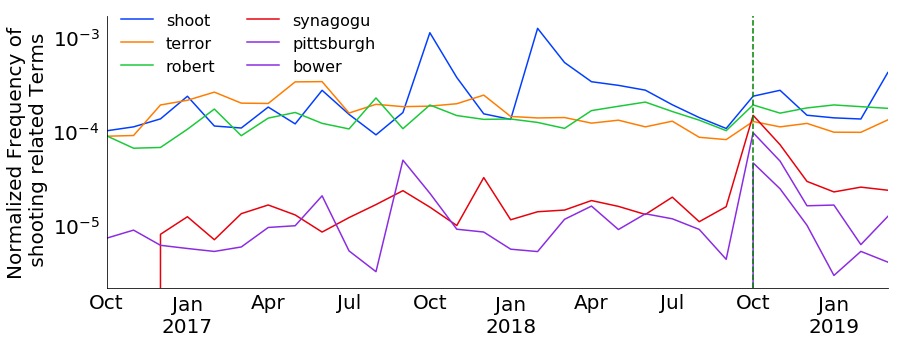

In [47]:
df_plot = makeCountsDF(['bowers','robert', 'shooting','pittsburgh', 'synagogue', 'terrorism'] , normalize=True, topN = 100)

matplotlib.rcParams['text.usetex'] = False
fig, ax = plt.subplots(figsize = (14,5))

cmap = ListedColormap(seaborn.color_palette('bright', 5))#, as_cmap=True)
df_plot[reversed(df_plot.columns)].plot(ax=ax, colormap = cmap)
#ax.plot.bar(df_plot.index.values, df_plot.T, labels = df_plot.columns)
ax.legend(loc='upper left')
#ax.axvline(shootingDate,color='r')
#ax.set_yscale("log", nonposy='clip')

ax.set_xlabel("", size = 0)
ax.set_ylabel("Normalized Frequency of\n shooting related Terms", size = 20)
#ax.set_title("Anti-Semitic Occurences Over Time", size = 20)
ax.tick_params('both', which='both',labelsize=20)
#ax.tick_params('y', which='both',labelsize=20, labelrotation = 45)

ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) 
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim([pandas.Timestamp('2016-10-01'),None])
ax.yaxis.get_offset_text().set_fontsize(20)
ax.axvline(x=shootingDate, color='G', linestyle='--')
ax.set_yscale('log')
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(0, .9), fontsize = 16,frameon=False,ncol=2, labelspacing=.5)



plt.savefig("overtime_shooting.pdf", format = 'pdf',bbox_inches='tight')
plt.show()
#ax.yaxis.get_offset_text()